# Santander Bikes EDA

In [19]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.optimize as op
plt.style.use("dark_background") # Config plots for dark mode, delete if on light mode
plt.rcParams['figure.dpi'] = 150 # Hi-res plots

In [39]:
bike_data = pd.read_csv("C:/Users/dell/Desktop/M2R-Project/data/processed_df.csv")
index_col = bike_data.columns[0]
bike_data.set_index(index_col)
bike_data.head() # Load the processed bike data and inspect the first 5 rows

,Unnamed: 0,start_id,end_id,start_time,duration,end_time,dist
0,1,103,37,47260920,360,47261280,1.458333
1,2,39,539,47260920,120,47261040,0.545517
2,3,785,785,47260920,300,47261220,0.000000
3,4,341,159,47260980,1800,47262780,1.092775
4,5,708,573,47260980,1080,47262060,3.607290


In [21]:
station_data = pd.read_csv("../data/santander_locations.csv")
station_data.head() # Load the station data and inspect the first 5 rows

,Station.Id,StationName,longitude,latitude,Easting,Northing
0,1,"River Street, Clerkenwell",-0.109971,51.5292,531202.520,182832.020
1,2,"Phillimore Gardens, Kensington",-0.197574,51.4996,525207.070,179391.860
2,3,"Christopher Street, Liverpool Street",-0.084606,51.5213,532984.810,182001.530
3,4,"St. Chad's Street, King's Cross",-0.120974,51.5301,530436.760,182911.990
4,5,"Sedding Street, Sloane Square",-0.156876,51.4931,528051.649,178742.097


## Bike Journey EDA

In [22]:
n_weeks = len(os.listdir("../data/santander_summaries")) # Number of files in santander_summaries corresponds to number of weeks we have data for
n_events = bike_data.shape[0] # Number of rows in processed dataframe corresponds to the number of events we have data for
time_elapsed = bike_data.start_time.max() - bike_data.start_time.min()

duration = bike_data.duration
dist = bike_data.dist

mean_duration = duration.mean()
mean_dist = dist.mean()

mode_duration = duration.mode().get(0)
mode_dist = dist.mode().get(0)

median_duration = duration.median()
median_dist = dist.median()

duration_std = duration.std()
dist_std = dist.std()

max_duration = duration.max()
max_dist = dist.max()

min_duration = duration.min()
min_dist = dist.min() # Compute some basic summary statistics for journey distance and duration using pandas built-in methods


In [23]:
print("Over the period of " + str(n_weeks) + " weeks, " + str(n_events) + " Santander bikes were used") # Some facts (EDA) about the journeys
print("\n")
print("The mean duration of a bike ride was " + str(round(mean_duration, 2)) + "s, or " + str(round(mean_duration / 60, 2)) + " min")
print("The mean distance of a bike ride was " + str(round(mean_dist, 2)) + "Km")
print("\n")
print("The standard deviation of the duration of a bike ride was " + str(round(duration_std, 2)) + "s, or " + str(round(duration_std / 60, 2)) + " min (≈ 1 hour)")
print("The standard deviation of the distance of a bike ride was " + str(round(dist_std, 2)) + "Km")
print("\n")
print("The mode duration of a bike ride was " + str(round(mode_duration, 2)) + "s, or " + str(round(mode_duration / 60, 2)) + " min")
print("The mode distance of a bike ride was " + str(round(mode_dist, 2)) + "Km, meaning the most popular use of Santander bikes is to rent and dock a bike at the same station")
print("\n")
print("The median duration of a bike ride was " + str(round(median_duration, 2)) + "s, or " + str(round(median_duration / 60, 2)) + " min")
print("The median distance of a bike ride was " + str(round(median_dist, 2)) + "Km")
print("\n")
print("The longest bike ride took " + str(round(max_duration, 2)) + "s, which is or " + str(round(max_duration / 60, 2)) + " min or " + str(round(max_duration / (60**2), 2)) + " hours, which is about " + str(round(max_duration / (60**2*24), 2)) + " days!")
print("The longest distance travelled between stations was " + str(round(max_dist, 2)) + "Km")
print("\n")
print("The shortest bike ride took " + str(round(min_duration, 2)) + "s, hypothetically corresponding to the refresh time of the data collection")
print("The shortest distance travelled between stations was " + str(round(min_dist, 2)) + "Km, corresponding to renting and docking a bike at the same station")

Over the period of 16 weeks, 3961103 Santander bikes were used


The mean duration of a bike ride was 1423.41s, or 23.72 min
The mean distance of a bike ride was 2.28Km


The standard deviation of the duration of a bike ride was 4067.3s, or 67.79 min (≈ 1 hour)
The standard deviation of the distance of a bike ride was 1.67Km


The mode duration of a bike ride was 660s, or 11.0 min
The mode distance of a bike ride was 0.0Km, meaning the most popular use of Santander bikes is to rent and dock a bike at the same station


The median duration of a bike ride was 960.0s, or 16.0 min
The median distance of a bike ride was 1.96Km


The longest bike ride took 565980s, which is or 9433.0 min or 157.22 hours, which is about 6.55 days!
The longest distance travelled between stations was 16.75Km


The shortest bike ride took 60s, hypothetically corresponding to the refresh time of the data collection
The shortest distance travelled between stations was 0.0Km, corresponding to renting and docking a 

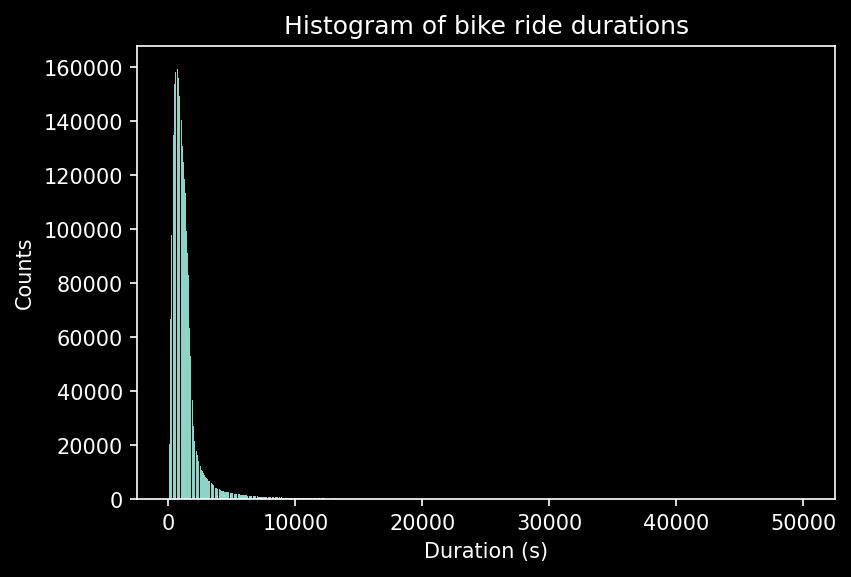

In [24]:
plt.figure(1)
plt.title("Histogram of bike ride durations")
plt.xlabel("Duration (s)")
plt.ylabel("Counts")
plt.hist(duration, bins=1000 ,range=(duration.min(), 50000)) # Plot histogram of bike ride durations, 50000 was chosen as 
plt.show()                                                   # it represents the data's trends clearly

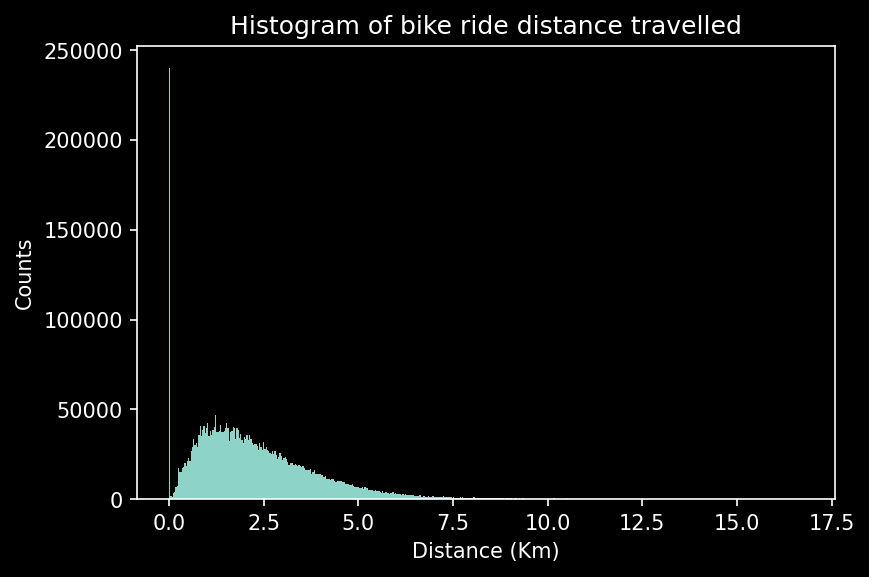

In [25]:
plt.figure(2)
plt.xlabel("Distance (Km)")
plt.ylabel("Counts")
plt.title("Histogram of bike ride distance travelled")
b,n,d = plt.hist(dist, bins=500 ) # Plot histogram of bike ride distances, 500 was chosen as it shows the data's trends more effectively
plt.show()
# Note the sharp peak at 0, corresponding to our mode of 0

## Station EDA

In [26]:
class StationIdError(IndexError):
    """Called when we try and read a non-existing station Id"""
    pass

def get_station_name(in_id):
    """Get station name from bike_data for a given id, catching any exceptions"""
    try:
        return station_data[station_data["Station.Id"] == in_id].StationName.iloc[0]
    except IndexError:
        StationIdError("No station matching input ID")

In [27]:
start_stations = bike_data.start_id
end_stations = bike_data.end_id

pop_start_stat = start_stations.mode().get(0)
pop_end_stat = end_stations.mode().get(0)

print("Over the " + str(n_weeks) + " week period, the most popular starting station was " + get_station_name(pop_end_stat) + ", which also was the most popular end station")

# Some summary statistics (EDA) on the stations. TODO: Add more


Over the 16 week period, the most popular starting station was Hyde Park Corner, Hyde Park, which also was the most popular end station


## Point process visualisations

In [28]:
print(np.all(bike_data.start_time.sort_values().values == bike_data.start_time.values)) # Check if the data is already sorted

True


In [29]:
def plot_n_events(n, **kwargs):
    """Plot the first n events as a point process"""
    start_times = bike_data.start_time.values # Read the start times
    shifted_times = (start_times - start_times[0])[:n] # Subtract the zeroth time
    plt.figure(3)
    plt.scatter(shifted_times, np.zeros(len(shifted_times)), **kwargs) # Use np.zeros as we are not interested in the y-axis, we want a 1D plot
    ax = plt.gca()
    ax.get_yaxis().set_visible(False)
    plt.title("Visualisation of first " + str(n) + " events")
    plt.xlabel("Time from first event (s)")
    plt.show() # Plot as point process

def plot_n_unique_events(n, **kwargs):
    """Plot the first n events occurring at unique times as a point process"""
    start_times = bike_data.start_time.unique() # Read the unique start times
    shifted_times = (start_times - start_times[0])[:n]
    plt.figure(4)
    plt.scatter(shifted_times, np.zeros(len(shifted_times)), **kwargs)
    ax = plt.gca()
    ax.get_yaxis().set_visible(False)
    plt.title("Visualisation of first " + str(n) + " unique event times")
    plt.xlabel("Time from first event (s)")
    plt.show()

def plot_n_counting_process(n, **kwargs):
    """Plot the first n jumps in the counting process"""
    counting_process = bike_data.start_time.value_counts().sort_index().cumsum() # Count the freq of the values, sort them and compute the cumsum
    times = counting_process.index                                               # to find how many units we jump per time step (jumps non-uniform)
    freqs = counting_process.values
    times -= times[0] # Adjust for zeroth time
    plt.figure(5)
    plt.scatter(times[:n], freqs[:n], **kwargs)
    ax = plt.gca()
    plt.title("Counting process for first " + str(n) + " jumps")
    plt.xlabel("Time from first event (s)")
    plt.ylabel("Bikes rented")
    plt.show()

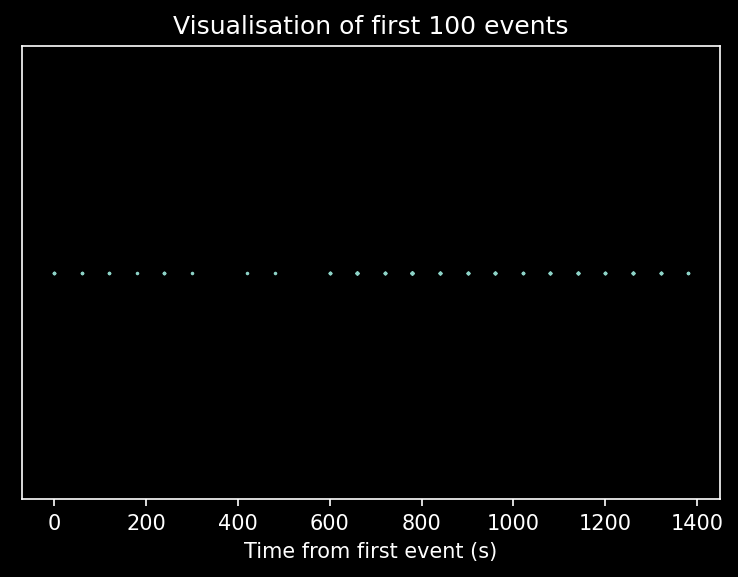

In [30]:
plot_n_events(100, s=0.5) # n = 100 with s=0.5 is a good choice to avoid too much clutter

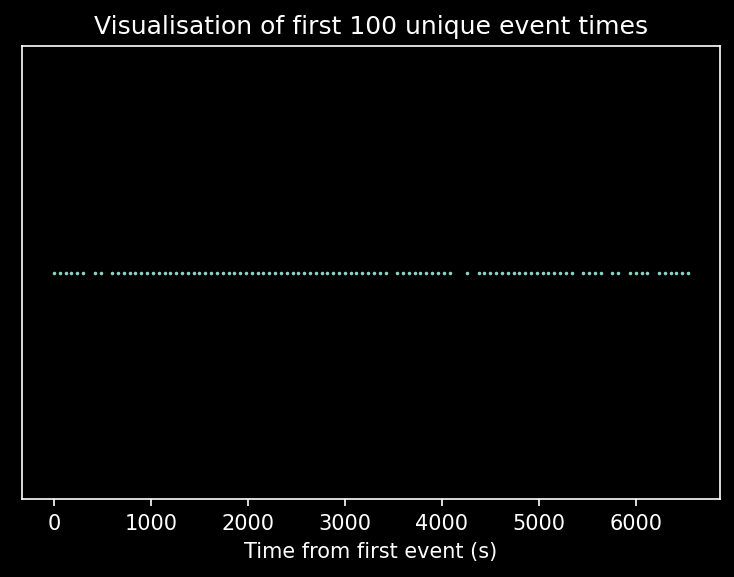

In [31]:
plot_n_unique_events(100, s=0.5)

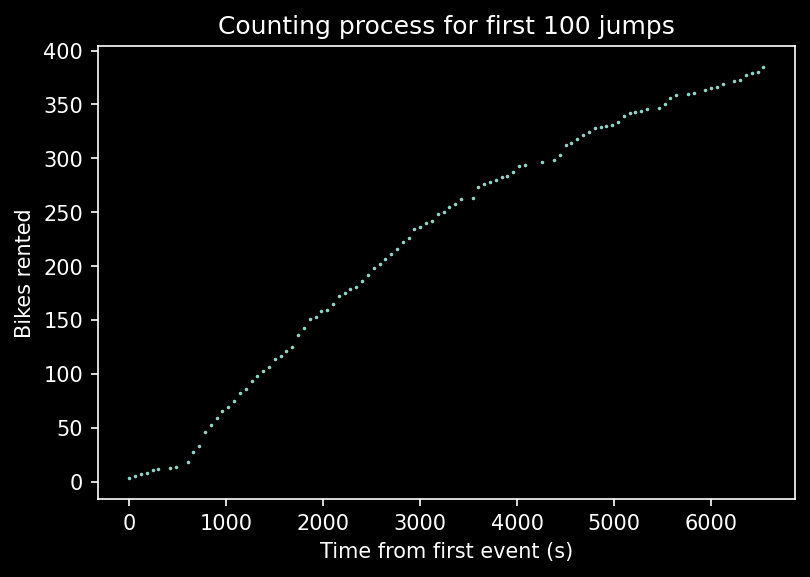

In [32]:
plot_n_counting_process(100, s=0.5)

## Fit Poisson

In [33]:
def fit_poisson_process(n, **kwargs):
    """Plot the first n jumps in the counting process"""
    counting_process = bike_data.start_time.value_counts().sort_index().cumsum() # Count the freq of the values, sort them and compute the cumsum
    times = counting_process.index.to_numpy()                                    # to find how many units we jump per time step (jumps non-uniform)
    freqs = counting_process.values
    times -= times[0] # Adjust for zeroth time
    times = times[:n]
    freqs = freqs[:n]
    max_time = times[-1]
    n_events = freqs[-1]
    timerange = [i for i in range(max_time)] # timerange for point process approx
    poisson_rate =  n_events / max_time
    poisson_fit = np.random.poisson(poisson_rate, max_time)
    S = [np.sum(poisson_fit[0:i]) for i in range(max_time)]
    plt.figure(5)
    plt.plot(timerange, S, color="green", linewidth=0.5)
    plt.scatter(times, freqs, **kwargs)
    ax = plt.gca()
    plt.title("Fitted Poisson Process for first " + str(n) + " jumps")
    plt.xlabel("Time from first event (s)")
    plt.ylabel("Bikes rented")
    plt.legend(["Fitted poisson process", "Observed events"], prop={'size': 8})
    plt.show() # ref: https://fromosia.wordpress.com/2017/03/19/stochastic-poisson-process/

In [34]:
counting_process = bike_data.start_time.value_counts().sort_index().cumsum() # Count the freq of the values, sort them and compute the cumsum
times = counting_process.index.to_numpy() 
print(len(times))

151652


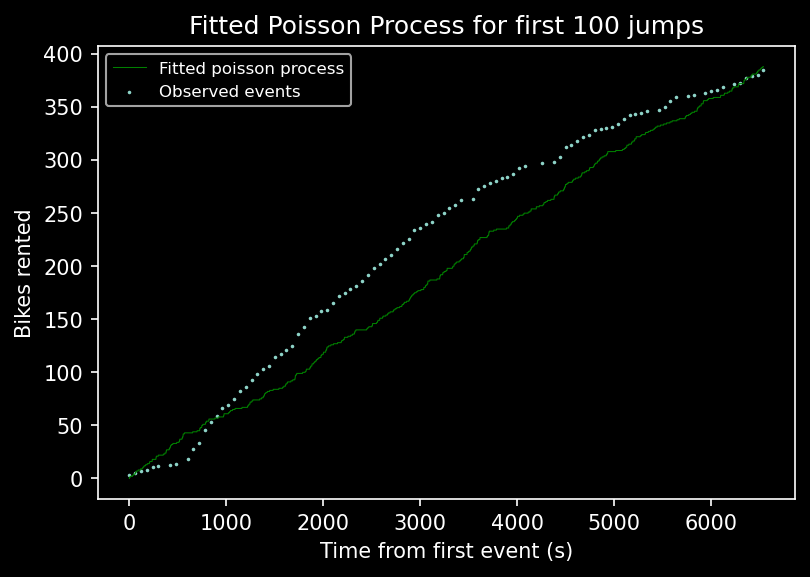

In [35]:
fit_poisson_process(100, s=0.5)

## Hawkes Process Log-L

Let the intensity function be
$$
\mu(t) = \alpha e^{-\beta t},\, \alpha \leq \beta
$$
Using Laub_15, we can calculate the log likelihood using the recursion:
$$
A(i) = e^{-\beta(t_i-t_{i-1})}(1+A(i-1))
$$

In [36]:
# def log_likelihood_hawkes_exp(k, alpha, beta):

#     def A(i):
#         if i==1:
#             return 1
#         else:
#             return np.exp(-1*beta*(t[i]-t[i-1]))*(1+A(i-1))

#     counting_process = bike_data.start_time.value_counts().sort_index().cumsum() # Count the freq of the values, sort them and compute the cumsum
#     times = counting_process.index.to_numpy()                                    # to find how many units we jump per time step (jumps non-uniform)
#     freqs = counting_process.values
#     times -= times[0] # Adjust for zeroth time
#     if k != 0:
#         times = times[:k]
#         freqs = freqs[:k]
#     max_time = times[-1]
#     n_events = freqs[-1]
#     t = [i for i in range(max_time)] # timerange for point process approx
#     poisson_rate =  n_events / max_time


#     first_sigma = 0
#     second_sigma = 0
#     for i in range(1, k+1):
#         first_sigma += np.log(poisson_rate + alpha*A(i)) 
#         second_sigma += (np.exp(-1*beta*(t[k] - t[i])) - 1)
#     second_sigma *= (alpha / beta)
#     extra_term = poisson_rate * t[k]
#     l = first_sigma - extra_term + second_sigma
#     return l

# log_likelihood_hawkes_exp(2000, 1, 2)

Attempt above was wrong, was using "continuous" time instead of the time at the events occur

In [37]:
def log_likelihood_hawkes_exp(k, alpha, beta):


    counting_process = bike_data.start_time.value_counts().sort_index().cumsum() # Count the freq of the values, sort them and compute the cumsum
    t = counting_process.index.to_numpy()                                    # to find how many units we jump per time step (jumps non-uniform)
    freqs = counting_process.values
    t -= t[0] # Adjust for zeroth time
    if k != 0:
        t = t[:k]
        t = t[:k]
    max_time = t[-1]
    n_events = freqs[-1]
     # timerange for point process approx
    poisson_rate =  n_events / max_time
    def A(i):
        if i == 1:
            return 0
        else:
            return np.exp(-1*beta * (t[i-1] - t[i-2]))*(1+A(i-1))
    
    l = 0

    for i in range(1, k+1):
        l += np.log(poisson_rate + alpha*A(i)) + (alpha/beta) * np.exp(-beta*(t[-1]-t[i-1])-1)
    l -= poisson_rate*t[-1]
    return l

log_likelihood_hawkes_exp(1000, 2, 5)

-3957000.0143164783

## Log Likelihood Minimisation

Using `scipy.optimise.minimise`, one can do MLE on the function above to find the values of $\alpha,\, \beta$ that best fit the Hawkes process to our data

In [38]:
n = 1000
log_likelihood_hawkes_exp_n = lambda x: log_likelihood_hawkes_exp(n, x[0], x[1])
bnds = ((0, np.inf), (0, np.inf))
x0 = [1,2]
cons = {'type': 'ineq', 'fun': lambda x: x[1] - x[0]}
sol = op.minimize(log_likelihood_hawkes_exp_n, x0, bounds=bnds, constraints=cons)
min_params_n = sol.x
print(min_params_n)

[1.11022302e-16 2.42215085e+00]


### Todo:
- [ ] Make figures nicer
- [X] Figure out how to fit a poisson process to the figure above
- [ ] Plot Hawkes process next to actual data for visualisation